In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

floatError = 1e-6 
path = "./"

In [26]:
class Parameter:
    gamma_b = 0.1 ## BOPS fee
    gamma_o = 0.2
    b = 0.3 ## Cross-sale profit
    wo = 0.2 ## Online retailer's unit cost
    ws = .2 ## Store's unit cost
    ks_l = 0.2
    ks_h = 0.4
    ko_l = 0.9
    ko_h = 0.8+0.2
    k_bar = 0.5*(ko_h + ko_l - ks_h - ks_l)

def optimal_price(alpha,BOPS,b):
    if BOPS: 
        ps = 1/(3-alpha)*((3+alpha)/2 + (3-alpha)*Parameter.gamma_b + (1+alpha)/(1-alpha)*Parameter.wo + 2*Parameter.ws)
        po = 1/(3-alpha)*(3/2 + 2/(1-alpha)*Parameter.wo + Parameter.ws)
    else:
        ps = 1/2 + 1/3*Parameter.wo + 2/3*Parameter.ws -2*b/3 + Parameter.k_bar/3
        po = 1/2 + 2/3*Parameter.wo + 1/3*Parameter.ws - 1/3*b - Parameter.gamma_o - Parameter.k_bar/3
    return [ps,po]    

def calculate_profit(alpha,BOPS,b):
    ps = optimal_price(alpha,BOPS,b)[0]
    po = optimal_price(alpha,BOPS,b)[1]
    Ds = Do = Db = 0
    if BOPS:
        if po - ps + Parameter.gamma_b >= 1/2:
            Ds = 1 #min(1, 1/2 + po - ps + Parameter.gamma_b)
            Db = 0 #max(0, 1/2 - po + ps - Parameter.gamma_b)
        elif po - ps + Parameter.gamma_b <= -1/2:
            Ds = 0 #max(0, 1/2 - po + ps - Parameter.gamma_b)
            Db = 1 #max(0, 1/2 - po + ps - Parameter.gamma_b)
        else:
            Ds =  1/2 + po - ps + Parameter.gamma_b
            Db =  1/2 - po + ps - Parameter.gamma_b
        pi_s = Ds*(ps - Parameter.ws + b) + Db*(b + alpha*po + Parameter.gamma_b)
        pi_o = Db*(po - alpha*po - Parameter.wo)
    else:
        if po - ps + Parameter.gamma_o + Parameter.k_bar >= 1/2:
            Ds = 1 #min(1, 1/2 + po - ps + Parameter.gamma_o + Parameter.k_bar)
            Do = 0 #max(0, 1/2 - po + ps - Parameter.gamma_o - Parameter.k_bar)
        elif po - ps + Parameter.gamma_o + Parameter.k_bar <= -1/2:
            Ds = 0 #max(0, 1/2 - po + ps - Parameter.gamma_b)
            Do = 1 #max(0, 1/2 - po + ps - Parameter.gamma_b)
        else:
            Ds = 1/2 + po - ps + Parameter.gamma_o + Parameter.k_bar
            Do = 1/2 - po + ps - Parameter.gamma_o - Parameter.k_bar
        pi_s = Ds * (ps - Parameter.ws + b)
        pi_o = Do * (po - Parameter.wo + Parameter.gamma_o)
    return [pi_s,pi_o, Ds, Do, Db]

def profit_function(alpha,BOPS,b):
    ea = 3/2 + Parameter.ws + 2/(1-alpha)*Parameter.wo
    eb = alpha/2 + Parameter.ws - Parameter.wo
    eta = 1/2 - 1/(3-alpha)*eb
    if BOPS:
        #pi_s = (Parameter.gamma_b+b)-1/(3-alpha)**2*(-alpha+3/2-Parameter.ws+Parameter.wo)**2+alpha+alpha/(1-alpha)*(Parameter.ws-1/2)
        pi_s = (Parameter.gamma_b+b) + ea/(3-alpha)*((1+alpha)/2+(alpha-1)/(3-alpha)*eb)+(1/2-1/(3-alpha)*eb)*(eb/(3-alpha)-Parameter.ws)
        #pi_s = (Parameter.gamma_b+b) + eta*(eb/(3-alpha)-Parameter.ws) + ea/(3-alpha)*((1-alpha)*eta+alpha)
        pi_o = (1-alpha)/(3-alpha)**2*(3/2 + Parameter.ws -Parameter.wo)**2
    else:
        pi_s = (1/2 - 1/3*Parameter.ws + 1/3*Parameter.wo + 1/3*b +1/3*Parameter.k_bar)**2
        pi_o = (1/2 + 1/3*Parameter.ws - 1/3*Parameter.wo - 1/3*b -1/3*Parameter.k_bar)**2
    return [pi_s,pi_o]

In [27]:
## Print b - data set

list_b = np.linspace(0,2,101)
list_alpha = np.linspace(0,1,101)
list_alpha = list_alpha[:40]

d= {'alpha':[],'b':[],'ps':[],'po':[],'pi_o':[],'pi_s':[],'BOPS':[],'alge_pi_o':[],'alge_pi_s':[]}
print_b = pd.DataFrame(data = d)
for b in list_b:
    for alpha in list_alpha:
        for BOPS in [0,1]:
            a = calculate_profit(alpha,BOPS,b)
            p = optimal_price(alpha,BOPS,b)
            profit = profit_function(alpha,BOPS,b)
            new = {'alpha':alpha,'b':b,'ps':p[0],'po':p[1],'pi_o':a[1],'pi_s':a[0],'BOPS':BOPS,'alge_pi_o':profit[1],'alge_pi_s':profit[0]}
            print_b = print_b.append(new,ignore_index=True)
print_b.to_csv(path + "print_b.csv")




In [28]:
def print_b (alpha_chosen):
    data = pd.read_csv(path+ "print_b.csv")
    data = data[ np.abs(data['alpha'] - alpha_chosen) < floatError ]
    fig =plt.figure()
    plt.plot(data[data['BOPS'] == 0]['b'],data[data['BOPS'] == 0]['pi_s'],label="Store's profit (noBOPS)")
    plt.plot(data[data['BOPS'] == 0]['b'],data[data['BOPS'] == 0]['pi_o'],label="Online's profit (noBOPS)")
    plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['pi_s'],label="Store's profit (BOPS)")
    plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['pi_o'],label="Online's profit (BOPS)")
    #plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['alge_pi_s'],label="AG Store's profit (BOPS)")
    #plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['alge_pi_o'],label="AG Online's profit (BOPS)")
    #plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['total_profit'],label="Total Profit (BOPS)")
    #plt.plot(data[data['BOPS'] == 0]['b'],data[data['BOPS'] == 0]['total_profit'],label="Total Profit (noBOPS)")
    plt.xlabel('b')
    plt.ylabel('Profit')
    plt.legend()
    plt.title(f'Profit Change(alpha = {alpha_chosen})')
    fig.savefig(path + f'Profit Change(alpha = {alpha_chosen}).png',dpi = 400)

def profit_alpha(b):
    data = pd.read_csv(path+ "print_b.csv")
    data = data[  np.abs(data['b'] - b) < floatError ] 

    fig =plt.figure()
    plt.plot(data[data['BOPS'] == 0]['alpha'],data[data['BOPS'] == 0]['pi_s'],label="Store's profit (noBOPS)")
    plt.plot(data[data['BOPS'] == 0]['alpha'],data[data['BOPS'] == 0]['pi_o'],label="Online's profit (noBOPS)")
    plt.plot(data[data['BOPS'] == 1]['alpha'],data[data['BOPS'] == 1]['pi_s'],label="Store's profit (BOPS)")
    plt.plot(data[data['BOPS'] == 1]['alpha'],data[data['BOPS'] == 1]['pi_o'],label="Online's profit (BOPS)")
    #plt.plot(data[data['BOPS'] == 1]['alpha'],data[data['BOPS'] == 1]['total_profit'],label="Total Profit (BOPS)")
    #plt.plot(data[data['BOPS'] == 0]['alpha'],data[data['BOPS'] == 0]['total_profit'],label="Total Profit (noBOPS)")
    
    plt.xlabel('alpha')
    plt.ylabel('Profit')
    plt.legend()
    plt.title(f"Profit Change(b={b})")
    fig.savefig(path + f'Profit Change(b={b}).png',dpi = 400)

def pricing_alpha (b):
    data = pd.read_csv(path+ "print_b.csv")
    data = data[  np.abs(data['b'] - b) < floatError ] 

    plt.plot(data[data['BOPS'] == 0]['alpha'],data[data['BOPS'] == 0]['ps'],label="Store's optimal price (noBOPS)")
    plt.plot(data[data['BOPS'] == 0]['alpha'],data[data['BOPS'] == 0]['po'],label="Online's optimal price (noBOPS)")
    plt.plot(data[data['BOPS'] == 1]['alpha'],data[data['BOPS'] == 1]['ps'],label="Store's optimal price (BOPS)")
    plt.plot(data[data['BOPS'] == 1]['alpha'],data[data['BOPS'] == 1]['po'],label="Online's optimal price (BOPS)")
    
    
    plt.xlabel('alpha')
    plt.ylabel('Price')
    plt.legend()
    plt.title(f"Pricing(b={b})")
    fig.savefig(path + f'Profit Change(b={b}).png',dpi = 200)


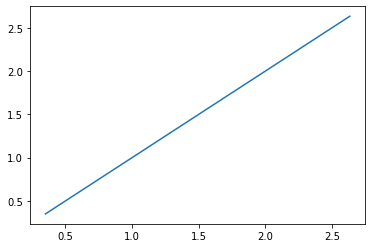

In [29]:
data = pd.read_csv(path+ "print_b.csv")
data = data[data["BOPS"] == 1]
plt.plot(data['pi_s'],data['alge_pi_s'])

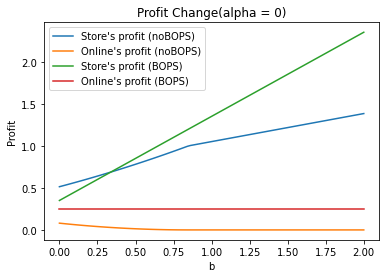

In [30]:
## print_b (alpha_chosen)
print_b(0)

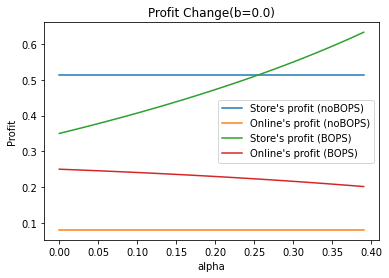

In [31]:
#print_alpha(0.02)
profit_alpha(0.00)

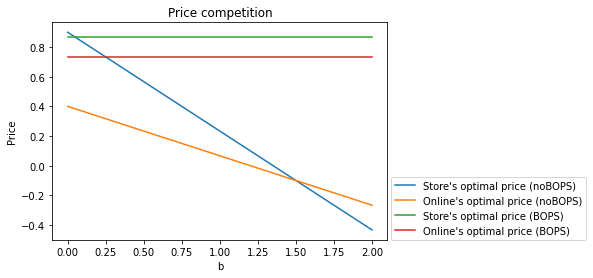

In [7]:
## Price Competition
data = pd.read_csv(path+ "print_b.csv")
data = data[data['alpha'] == 0]

fig =plt.figure()
plt.plot(data[data['BOPS'] == 0]['b'],data[data['BOPS'] == 0]['ps'],label="Store's optimal price (noBOPS)")
plt.plot(data[data['BOPS'] == 0]['b'],data[data['BOPS'] == 0]['po'],label="Online's optimal price (noBOPS)")
plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['ps'],label="Store's optimal price (BOPS)")
plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['po'],label="Online's optimal price (BOPS)")
plt.xlabel('b')
plt.ylabel('Price')
plt.legend(loc=[1.01, 0])
plt.title(f'Price competition')
fig.savefig(path + 'Price competition.png',dpi = 400)


In [8]:
## Profit Share
data = pd.read_csv(path+ "print_b.csv")
data = data[data['alpha'] == 0]

fig = plt.figure()
plt.plot(data[data['BOPS'] == 0]['b'],data[data['BOPS'] == 0]['from_product'],label="From product (noBOPS)")
plt.plot(data[data['BOPS'] == 0]['b'],data[data['BOPS'] == 0]['from_crossselling'],label="From crossselling (noBOPS)")
plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['from_product'],label="From product (BOPS)")
plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['from_crossselling'],label="From crossselling (BOPS)")
plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['from_service'],label="From service (BOPS)")
plt.plot(data[data['BOPS'] == 1]['b'],data[data['BOPS'] == 1]['pi_o'],label="Online's Profit (BOPS)")

plt.xlabel('b')
plt.ylabel('Profit')
plt.legend()
plt.title(f"Store's Profit Share")
fig.savefig(path + "Store's Profit Share.png",dpi = 400)


KeyError: 'from_product'

In [9]:
# Set b = 0 

In [9]:
list_w = np.linspace(0,2,6)
list_kbar = np.arange(0,1,0.05)
list_gamma = np.linspace(0,2,6)
list_alpha = np.linspace(0,1,51)
b=0
d= {'ws':[],'wo':[],'gamma_o':[],'gamma_b':[],'k_bar':[],'accept_alpha':[],'online_better_off':[]}
data_accept_alpha = pd.DataFrame(data = d)

for Parameter.k_bar in list_kbar[0:]:
    for ws in list_w:
        Parameter.ws = ws
        for wo in list_w:
            Parameter.wo = wo
            for gamma_b in list_gamma:
                Parameter.gamma_b = gamma_b
                for gamma_o in list_gamma:
                    Parameter.gamma_o = gamma_o
                    if Parameter.gamma_o >= Parameter.gamma_b:
                        accept_alpha = 0.999999999
                        online_better_off = 'No'
                        for alpha in list_alpha[:50]:
                            if calculate_profit(alpha,0,b)[0] <= calculate_profit(alpha,1,b)[0]:
                                accept_alpha = alpha
                                break
                        if calculate_profit(accept_alpha,0,b)[1] <= calculate_profit(accept_alpha,1,b)[1]:
                            online_better_off = 'Yes'
                        new = {'k_bar': Parameter.k_bar,'ws':Parameter.ws,'wo':Parameter.wo,'gamma_o':Parameter.gamma_o,'gamma_b':Parameter.gamma_b,'accept_alpha':accept_alpha, 'online_better_off':online_better_off}
                        data_accept_alpha = data_accept_alpha.append(new,ignore_index=True)
data_accept_alpha.to_csv(path + "data_accept_alpha.csv")                
                #print(Parameter.ws,Parameter.wo,Parameter.gamma_b,Parameter.gamma_o)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='accept_alpha', ylabel='Density'>

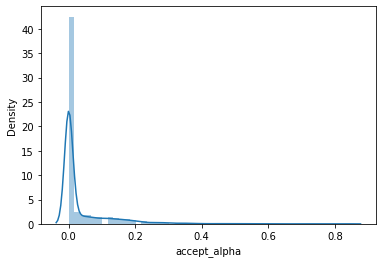

In [11]:
data = pd.read_csv(path+ "data_accept_alpha.csv")  
sns.distplot(data['accept_alpha'])

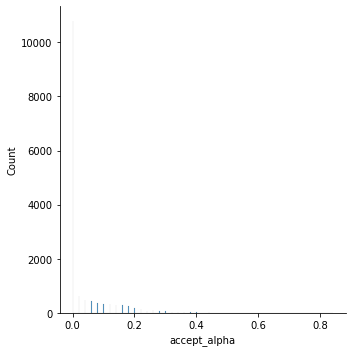

In [12]:
sns.displot(data['accept_alpha'])


In [13]:
data = pd.read_csv(path+ "data_accept_alpha.csv")  
data[data['accept_alpha'] > 0.999999]
#pd.set_option('display.max_rows', 8000)
#data[np.abs(data['k_bar'] - 0.3)<1e-6]
## When wo= 0, ws= 0, gamma_b = 0 and k_bar is large enough-> There is no alpha will incentivize physical retailer

,Unnamed: 0,ws,wo,gamma_o,gamma_b,k_bar,accept_alpha,online_better_off


,Unnamed: 0,ws,wo,gamma_o,gamma_b,k_bar,accept_alpha
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.0,221.000000
mean,398.895928,1.047964,1.127602,1.355656,0.615385,0.0,0.004072
std,214.187244,0.645021,0.568737,0.600929,0.588942,0.0,0.008072
min,25.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,205.000000,0.400000,0.800000,0.800000,0.000000,0.0,0.000000
50%,398.000000,1.200000,1.200000,1.600000,0.400000,0.0,0.000000
75%,579.000000,1.600000,1.600000,2.000000,0.800000,0.0,0.000000
max,754.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.020000


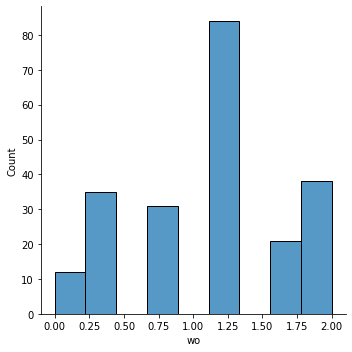

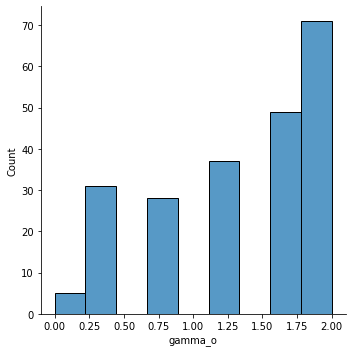

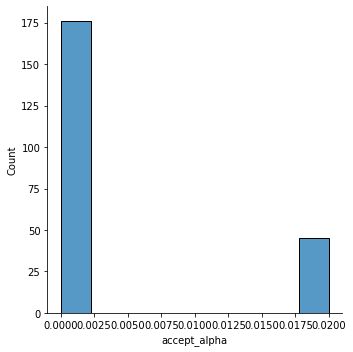

In [14]:
data = pd.read_csv(path+ "data_accept_alpha.csv")  
#data = data[data['accept_alpha'] < 0.99]
# data['cost_diff'] = data['ws'] - data ['wo']
# sns.distplot(data[data['online_better_off'] == 'No']['cost_diff'])
sns.displot(data[data['online_better_off'] == 'No']['wo'])
sns.displot(data[data['online_better_off'] == 'No']['gamma_o'])
sns.displot(data[data['online_better_off'] == 'No']['accept_alpha'])
# sns.displot(data[data['online_better_off'] == 'No']['k_bar'])
# pd.set_option('display.max_rows', 300000)
data[data['online_better_off'] == 'No'].describe()
## When online's cost is much higher than store's cost, online store cannot benefit from more BOPS, even though it sells more when BOPS. 
## The underlying reason is that there will not be shipping revenue from BOPS. 
## However, for most of the time, the cost between these two is not that large.

In [ ]:
class Parameter:
    gamma_b = 0.1 ## BOPS fee
    gamma_o = 0.2
    b = 0.8 ## Cross-sale profit
    wo = 2 ## Online retailer's unit cost
    ws = 0.3 ## Store's unit cost
    ks_l = 0.2
    ks_h = 0.4
    ko_l = 0.6
    ko_h = 0.8
    k_bar = 0.5*(ko_h + ko_l - ks_h - ks_l)

def optimal_price(alpha,BOPS,b):
    if BOPS: 
        ps = 1/(3-alpha)*((3-alpha)/2 + (3-alpha)*Parameter.gamma_b + (1+alpha)/(1-alpha)*Parameter.wo + 2*Parameter.ws)
        po = 1/(3-alpha)*(3/2 + 2/(1-alpha)*Parameter.wo + Parameter.ws)
    else:
        ps = 1/2 + 1/3*Parameter.wo + 2/3*Parameter.ws -2*b/3 + Parameter.k_bar/3
        po = 1/2 + 2/3*Parameter.wo + 1/3*Parameter.ws - 1/3*b - Parameter.gamma_o - Parameter.k_bar/3
    return [ps,po]    

def calculate_profit(alpha,BOPS,b):
    ps = optimal_price(alpha,BOPS,b)[0]
    po = optimal_price(alpha,BOPS,b)[1]
    Ds = Do = Db = 0
    if BOPS:
        if po - ps + Parameter.gamma_b >= 1/2:
            Ds = 1 #min(1, 1/2 + po - ps + Parameter.gamma_b)
            Db = 0 #max(0, 1/2 - po + ps - Parameter.gamma_b)
        elif po - ps + Parameter.gamma_b <= -1/2:
            Ds = 0 #max(0, 1/2 - po + ps - Parameter.gamma_b)
            Db = 1 #max(0, 1/2 - po + ps - Parameter.gamma_b)
        else:
            Ds =  1/2 + po - ps + Parameter.gamma_b
            Db =  1/2 - po + ps - Parameter.gamma_b
        pi_s = Ds*(ps - Parameter.ws + b) + Db*(b + alpha*po + Parameter.gamma_b)
        pi_o = Db*(po - alpha*po - Parameter.wo)
    else:
        if po - ps + Parameter.gamma_o + Parameter.k_bar >= 1/2:
            Ds = 1 #min(1, 1/2 + po - ps + Parameter.gamma_o + Parameter.k_bar)
            Do = 0 #max(0, 1/2 - po + ps - Parameter.gamma_o - Parameter.k_bar)
        elif po - ps + Parameter.gamma_o + Parameter.k_bar <= -1/2:
            Ds = 0 #max(0, 1/2 - po + ps - Parameter.gamma_b)
            Do = 1 #max(0, 1/2 - po + ps - Parameter.gamma_b)
        else:
            Ds = 1/2 + po - ps + Parameter.gamma_o + Parameter.k_bar
            Do = 1/2 - po + ps - Parameter.gamma_o - Parameter.k_bar
        pi_s = Ds * (ps - Parameter.ws + b)
        pi_o = Do * (po - Parameter.wo + Parameter.gamma_o)
    return [pi_s,pi_o, Ds, Do, Db]

